## The Usual Preamble

This time around, we're going to be using larcv for the objects in file. In addition, ROOT will be used for the native capabilities to pull objects out of file.

In [1]:
from larcv import larcv
from ROOT import TChain
import numpy as np
import scipy.misc as smp
%matplotlib inline

Welcome to ROOTaaS 6.06/08


## Reading the Contents of Files
Here, larcv's iomanager is going to be used to automatically parse the contents of the `test.root` file.

In [2]:
# Initializes the IO Manager to read out the inference file
io=larcv.IOManager(larcv.IOManager.kREAD)
io.add_in_file('../test.root')
io.initialize()

# Here, kProductUnkown is part of an enum used to specify the types of objects in file
for x in xrange(larcv.kProductUnknown):
    # producers are the classes responsible for creating the objects in file
    producers=io.producer_list(x)
    print 'Producer type:',x,'(aka',larcv.ProductName(x),'):'
    for p in producers: print p

Producer type: 0 (aka image2d ):
pmt
segment_hires_crop
tpc_hires_crop
Producer type: 1 (aka partroi ):
tpc_hires_crop
Producer type: 2 (aka chstatus ):
tpc
Producer type: 3 (aka pixel2d ):
    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: ../test.root
    [NORMAL]  <IOManager::initialize> Prepared input with 42500 entries...


As we can see above, there are 3 types of 2DImages in file. One for the TPC, one for the semantic segmentation output and one for the PMT projections.

Partroi holds arrays denoting the regions of interest 

The channel status (which ones are dead channels) is only produced from the TPC.

In addition, the IOManager will output various information to std::out. These are the last two lines.

## Using ROOT to read objects in File.

Below uses a ROOT TChain to read objects out of file. 

### Reading a single image
The first example below simply pulls a single object out of file.

In [3]:
# Sets up the TChain to pull entries from the tree named below.
pixel_tree_name='image2d_tpc_hires_crop_tree'
pixel_ch = TChain(pixel_tree_name)
pixel_ch.AddFile('../test.root')

# Pulls instance (aka Entry) `0` out of file and into memory.
# Feel free to change this index to fetch out whichever entry you want!
pixel_ch.GetEntry(0)
# Objects in memory are stored as members of the TChain
# Since these are dynamically named, the following hack is required to pull them out of the branch
pixel_br=getattr(pixel_ch, pixel_tree_name.replace('tree','branch'))
print "Class in Branch: ", pixel_br
#Now, we can pull out the channel, and the image corresponding to that channel
# Feel free to change this to any value in (0,2). This corresponds to plane number
image = pixel_br.at(2)
print "Image Class: ", image
print "Number of Pixels: ", image.size()
# All images are of the size 576,576.
# Fetches out the pixel value
print "Pixel Value at (575, 575): ", image.pixel(575,575)

Class in Branch:  <ROOT.larcv::EventImage2D object at 0x6b243e0>
Image Class:  <ROOT.larcv::Image2D object at 0x6b009b0>
Number of Pixels:  331776
Pixel Value at (575, 575):  0.0


### Drawing a Single Image

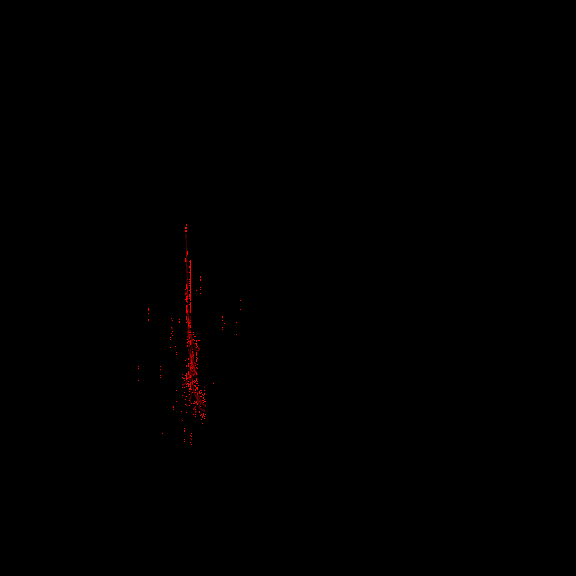

In [4]:
data = np.zeros( (576,576,3), dtype=np.uint8 )
for i in range(576):
    for j in range(576):
        data[i,j] = [image.pixel(i,j),0,0] 
img = smp.toimage( data )       # Create a PIL image
img.save('single_image.png')
from IPython.display import Image
Image(filename='single_image.png') 

## Creating a 3-Layer Image

I'm mostly doing this one for fun :)

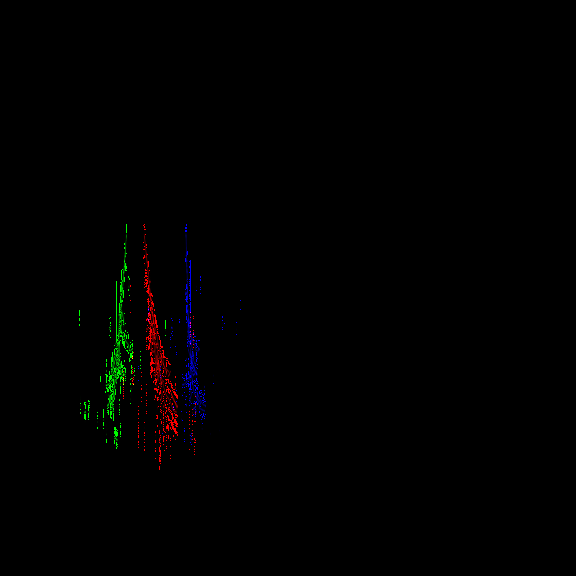

In [ ]:
data = np.zeros( (576,576,3), dtype=np.uint8 )
for i in range(576):
    for j in range(576):
        data[i,j] = [pixel_br.at(0).pixel(i,j),pixel_br.at(1).pixel(i,j),pixel_br.at(2).pixel(i,j)] 
img = smp.toimage( data )       # Create a PIL image
img.save('composite_image.png')
from IPython.display import Image
Image(filename='composite_image.png') 

## Looping Over Events in File

The code snippet below loops over all the events in file and pulls out the individual images.

In [ ]:
# Loops over the  intances stored in the file
for entry in xrange(pixel_ch.GetEntries()):
    pixel_ch.GetEntry(entry)
    pixel_br=getattr(pixel_ch, pixel_tree_name.replace('tree','branch'))
    for plane in range(3):
        image = pixel_br.at(plane)    

### Creating a composite image from all of the events'

Once again, this is done for fun, but demonstrates the ability to parse through data in batch.

In [ ]:
data = np.zeros( (576,576,3), dtype=np.float32 )
for entry in xrange(pixel_ch.GetEntries()):
    pixel_ch.GetEntry(entry)
    pixel_br=getattr(pixel_ch, pixel_tree_name.replace('tree','branch'))
    for plane in range(3):
        image = pixel_br.at(plane)
        for x in range(576):
            for y in range(576):
                data[x,y,plane] += float(image.pixel(x,y))/pixel_ch.GetEntries()
img = smp.toimage( data )
img.save('composite_image2.png')
from IPython.display import Image
Image(filename='composite_image2.png') 